# Description

Notebook for power calculation simulations in Appendix.

# Imports

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, t
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from linearmodels.iv.model import _OLS

In [2]:
import sys

sys.path.append("../src/rdd-discovery/utils/")

from sim import gen_fuzzy_rdd_first_stage
from rddd import test_discontinuity
from pwr import rdd_power

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

# First stage standard error posthoc power

In [5]:
cutoff = 0.5
seed = 42
take = 0
fuzzy_gap = 0.25
const = 0.1
noise_std=0.1
n = 1000

test_df = gen_fuzzy_rdd_first_stage(n_samples=n,
                                    fuzzy_gap=fuzzy_gap, 
                                    take=take, 
                                    seed=seed, 
                                    cutoff=cutoff, 
                                    use_covars=False,
                                    const=const,
                                    noise_std=noise_std,
                                    reg_dict=None)

In [6]:
# check standard errors, posthoc power
tau_hats = []
std_errs = []
pwrs = []
subgroup_size = []
alpha = 0.05

n_trials = 500

r2s = []
resids = []

upper_betas = []
lower_betas = []

for subset in [400, 600, 800]:
    for seed in tqdm(range(n_trials)):
        
        reg_df = test_df.sample(subset, random_state=seed+subset)
        reg_df['z'] = (reg_df['x'] >= cutoff).astype(int)
        reg_df['x_lower'] = (1-reg_df['z'])*(reg_df['x'] - cutoff) # adjusted x for 2SLS
        reg_df['x_upper'] = reg_df['z']*(reg_df['x'] - cutoff) # adjusted x for 2SLS

        ols_formula = f"t ~ 1 + x_lower + x_upper + z"
        ols_results = _OLS.from_formula(ols_formula, reg_df).fit(cov_type='unadjusted')
        
        upper_betas.append(ols_results.params['x_upper'])
        lower_betas.append(ols_results.params['x_lower'])
        
        tau_hats.append(ols_results.params['z'])
        std_errs.append(ols_results.std_errors['z'])
        pwrs.append(rdd_power(ols_results.params['z'], ols_results.std_errors['z']**2, alpha=alpha))
        subgroup_size.append(subset)
        
        u_resids = ols_results.resids
        resids.append(ols_results.resid_ss)
        r_formula = f"z ~ 1 + x_lower + x_upper"
        r_results = _OLS.from_formula(r_formula, reg_df).fit(cov_type="unadjusted")
        
        r_resids = r_results.resids
        r2s.append(r_results.rsquared)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 47.41it/s]


In [7]:
df = pd.DataFrame()

df['group_size'] = subgroup_size
df['upper_b'] = upper_betas
df['lower_b'] = lower_betas
df['r2s'] = r2s

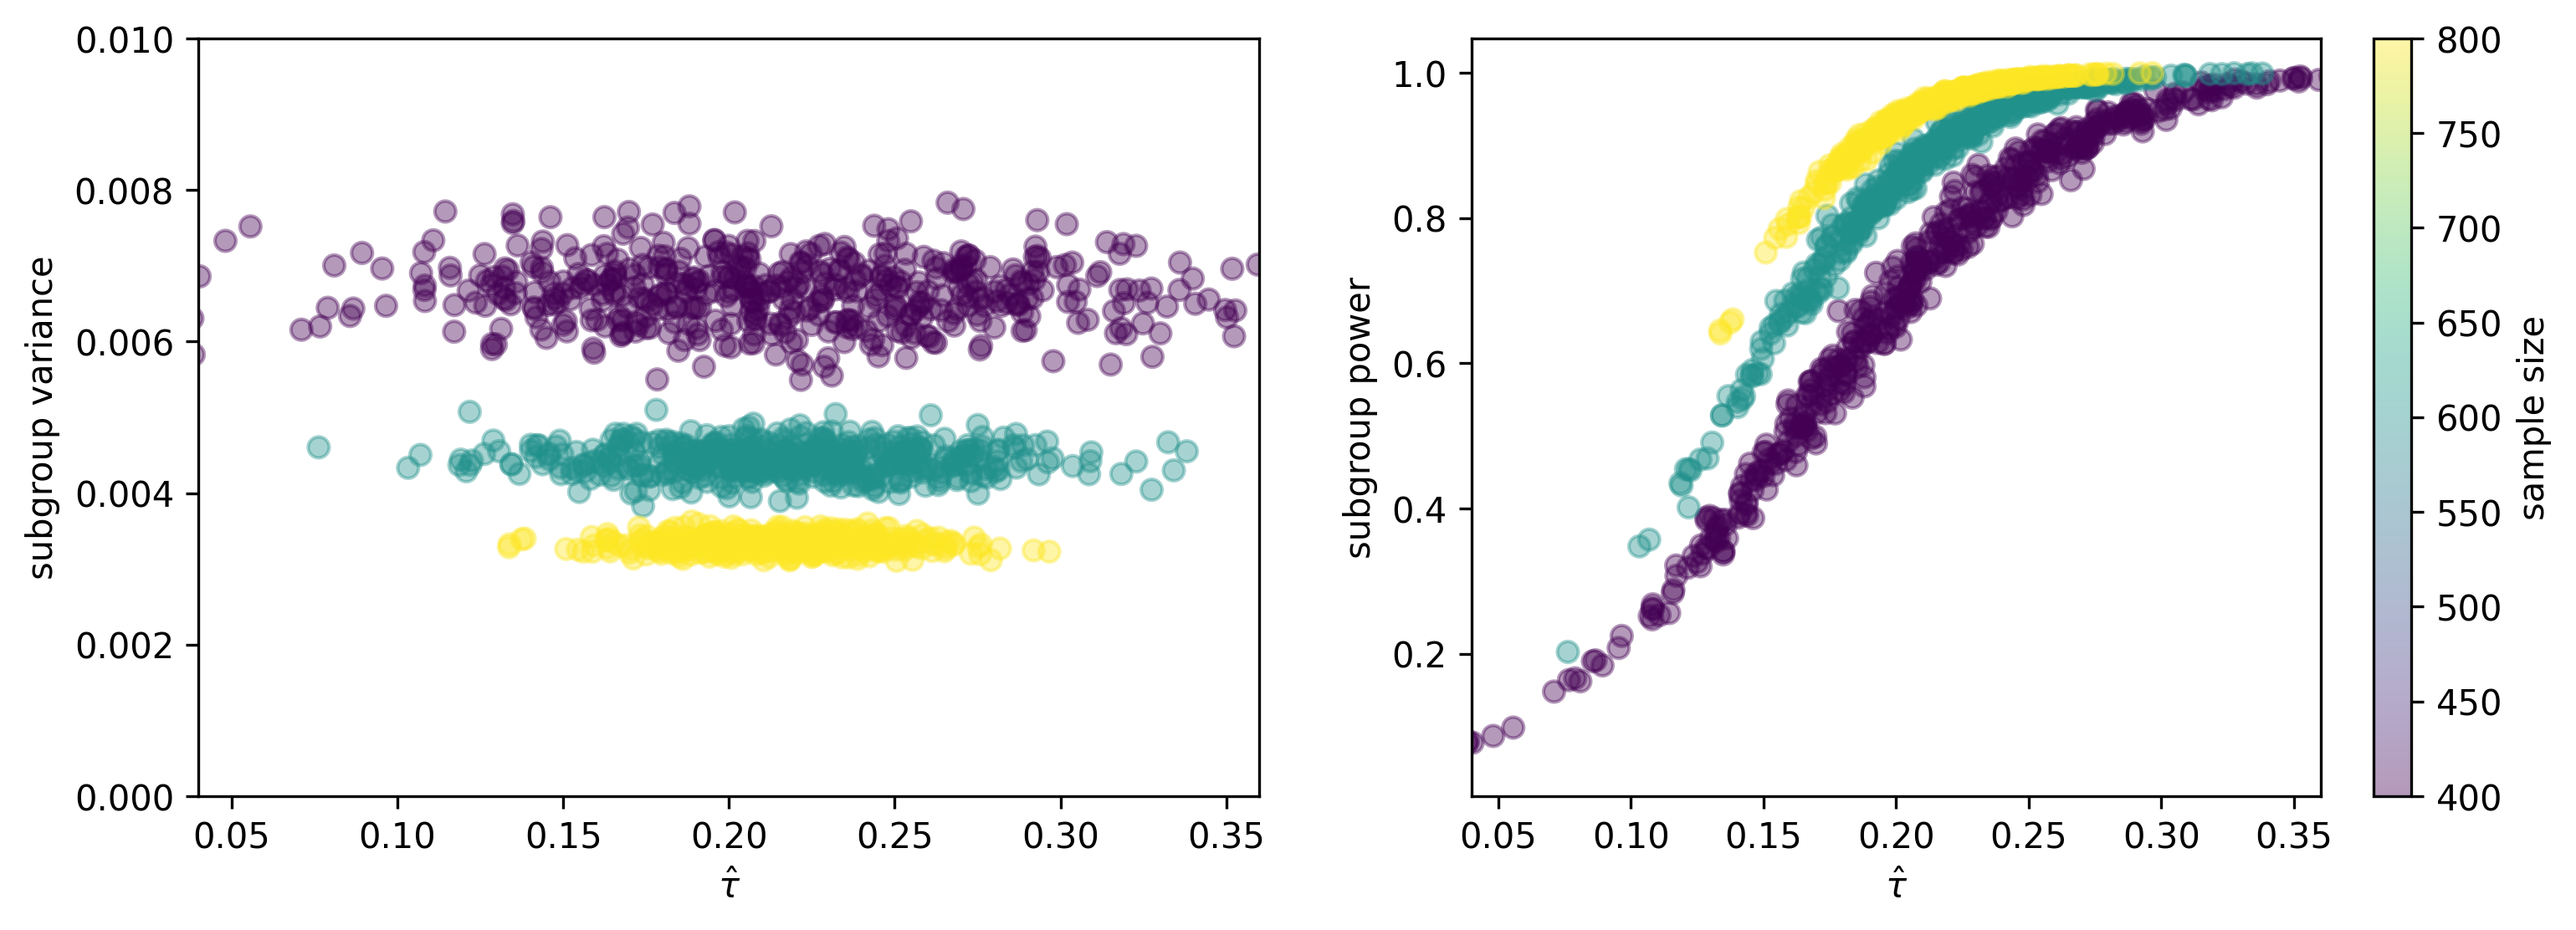

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

cm = ax1.scatter(x=tau_hats,
                y=np.array(std_errs)**2,#r2s,#np.array(std_errs)**2, 
                 alpha=0.4, c=subgroup_size)#, cmap="coolwarm")
#plt.colorbar(cm)
ax1.set_ylabel("subgroup variance")
ax1.set_xlabel("$\hat{\\tau}$")
ax1.set_xlim(0.04, 0.36)
fig.patch.set_facecolor('white')
ax1.set_ylim(0.0, 0.01)
#ax.axhline(y=0.08)
#ax.set_xlim(1.95, 3)

cm = ax2.scatter(x=np.array(tau_hats),# / np.array(std_errs),
                y=np.array(pwrs), alpha=0.4, c=subgroup_size)#, cmap="coolwarm")
plt.colorbar(cm, label="sample size")
#plt.colorbar(cm)
ax2.set_xlim(0.04, 0.36)
ax2.set_ylabel("subgroup power")
ax2.set_xlabel("$\hat{\\tau}$")
plt.savefig("../figures/app_tau_pwr.png", bbox_inches="tight")